In [2]:
import pandas as pd
import seaborn as sns
import time
import xgboost
import numpy as np
import matplotlib.pyplot as plt
import xgboost

from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef, accuracy_score

from src.modelling import hyperparameter_optimization

sns.set_theme(style="whitegrid")
sns.set_palette(palette="Paired")
SEED: int = 42

# Load Data

In [3]:
X_train = pd.read_csv("../../data/processed/train_data_cleaned.csv", index_col="building_id")
y_train = pd.read_csv("../../data/processed/train_labels.csv", index_col="building_id", usecols=["building_id", "damage_grade"])

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

X_train.head(5)

Shape of X_train: (260601, 18)
Shape of y_train: (260601, 1)


,count_families,count_floors_pre_eq,geo_level_1_id,geo_level_2_id,geo_level_3_id,has_secondary_use,has_superstructure_cement_mortar_brick,has_superstructure_mud_mortar_stone,age,area_percentage,superstructure_quality,foundation_type_r,ground_floor_type_f,ground_floor_type_v,land_surface_condition_t,other_floor_type_q,position_s,roof_type_n
building_id,,,,,,,,,,,,,,,,,,
802906,0.111111,0.125,0.200000,0.341275,0.970637,0.0,0.0,1.0,0.121343,0.247589,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
28830,0.111111,0.125,0.266667,0.630694,0.223761,0.0,0.0,1.0,0.040448,0.346625,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
94947,0.111111,0.125,0.700000,0.254380,0.714013,0.0,0.0,1.0,0.040448,0.198071,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
590882,0.111111,0.125,0.733333,0.292922,0.850959,0.0,0.0,1.0,0.040448,0.247589,0.5,1.0,1.0,0.0,1.0,0.0,1.0,1.0
201944,0.111111,0.250,0.366667,0.091801,0.118405,0.0,0.0,0.0,0.121343,0.346625,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0


In [4]:
# Take subsample for better runtime
X_train = X_train.iloc[:10000]
y_train = y_train.iloc[:10000]

# Get validation set to test SMOTE
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, stratify=y_train, test_size=0.2)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

Shape of X_train: (8000, 18)
Shape of y_train: (8000, 1)


# Base: Target Distribution

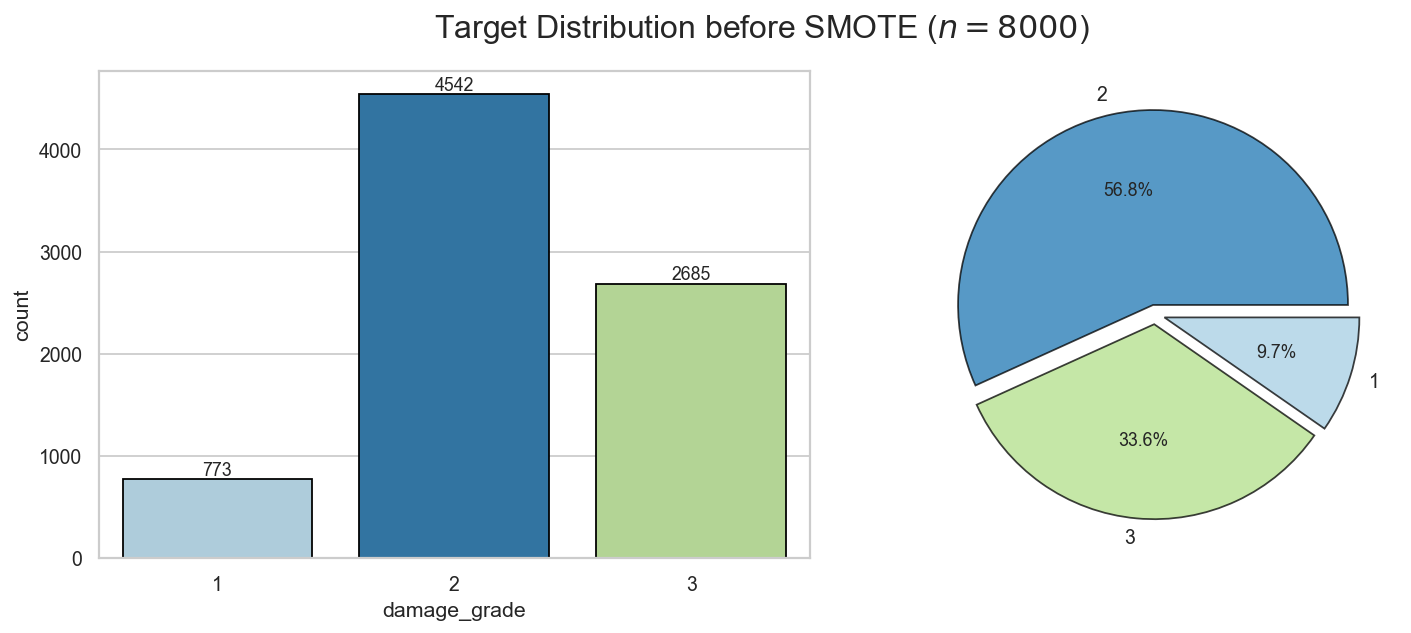

In [5]:
def plot_target_distribution(y_train: pd.DataFrame, title:str = "Target Distribution") -> None:
    """
    Expects single dataframe with only one column to analyse, i.e. target distribution
    :param y_train:
    :return:
    """
    # Get dict of winner with keys and corresponding values for plotting
    y_train_value_counts = y_train.value_counts()

    # Plot settings for winner distribution (barplot and pie chart)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=128)
    fig.suptitle(f"{title} ($n = {sum(y_train_value_counts.values)}$)",
                 size=18)
    g = sns.countplot(data=y_train, x="damage_grade", edgecolor="black", ax=axes[0], palette="Paired")
    g.bar_label(g.containers[0])
    axes[1].pie(x=y_train_value_counts,
                autopct='%1.1f%%',
                wedgeprops={"edgecolor":"black", "alpha": 0.75},
                labels=[int(x[0]) for x in y_train_value_counts.keys()],
                explode = np.full(shape=(len(y_train_value_counts.keys())), fill_value=0.05),
                colors=["#1f78b4", "#b2df8a", "#a6cee3"])
    fig.tight_layout()
    plt.show()

plot_target_distribution(y_train, title="Target Distribution before SMOTE")

# Base: Model Performance

In [6]:
model, cv_results = hyperparameter_optimization(model="XGBoost",
                                                train_data=X_train,
                                                train_labels=y_train,
                                                scoring=["accuracy", "matthews_corrcoef"])

Fitting XGBoost ...

CV Training ACC: 0.9991 +/- 0.0001 
CV Test ACC: 0.6781 +/- 0.0119

CV Training MCC: 0.9984 +/- 0.0002 
CV Test MCC: 0.3932 +/- 0.0228



In [7]:
%timeit

def get_prediction_score(model):
    # Predict on unseen
    y_pred = pd.DataFrame(model.predict(X_val))

    # Since XGBoost predicts [0, 1, 2] classes, we have to transform it to original class labels
    if isinstance(model, xgboost.XGBClassifier):
        print("XGBoost model was used. Renaming predictions ...")
        y_pred = y_pred.replace({0: 1, 1: 2, 2: 3})

    acc = accuracy_score(y_true=y_val, y_pred=y_pred)
    mcc = matthews_corrcoef(y_true=y_val, y_pred=y_pred)
    print(f"ACC on validation set: {acc:.4f}")
    print(f"MCC on validation set: {mcc:.4f}")

    return acc, mcc

acc_val_pre, mcc_val_pre = get_prediction_score(model)

XGBoost model was used. Renaming predictions ...
ACC on validation set: 0.6705
MCC on validation set: 0.3787


# SMOTE

In [8]:
from imblearn.over_sampling import SMOTE

In [9]:
sm = SMOTE(random_state=42, k_neighbors=7) # k_neighbors default is 5
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print(f"Resampled dataset shape: {y_train_res.shape}")

plot_target_distribution(y_train_res, title="Target Distribution after SMOTE")

Resampled dataset shape: (8000, 1)


In [11]:
model_post_smote, cv_results_post_smote = hyperparameter_optimization(model="XGBoost",
                                               train_data=X_train_res,
                                               train_labels=y_train_res,
                                               scoring=["accuracy", "matthews_corrcoef"])

Fitting XGBoost ...

CV Training ACC: 0.9995 +/- 0.0002 
CV Test ACC: 0.7688 +/- 0.0909

CV Training MCC: 0.9992 +/- 0.0003 
CV Test MCC: 0.6669 +/- 0.1243



In [12]:
# Get prediction from model post smote
acc_val_post, mcc_val_post = get_prediction_score(model_post_smote)

XGBoost model was used. Renaming predictions ...
ACC on validation set: 0.6565
MCC on validation set: 0.3624


# KMeansSmote

Resampled dataset shape: (13629, 1)


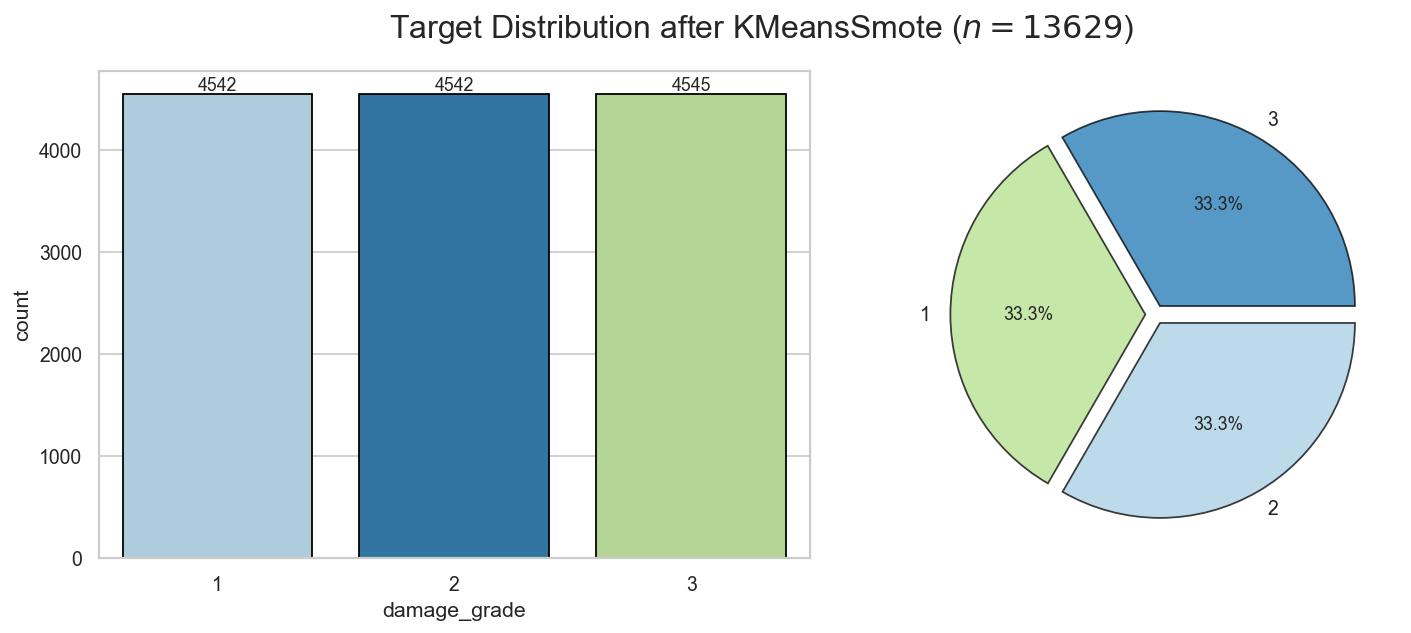

In [15]:
from imblearn.over_sampling import KMeansSMOTE
kmeanssmote = KMeansSMOTE(random_state=42, k_neighbors=7) # k_neighbors default is 5
X_train_kms, y_train_kms = kmeanssmote.fit_resample(X_train, y_train)
print(f"Resampled dataset shape: {y_train_kms.shape}")

plot_target_distribution(y_train_kms, title="Target Distribution after KMeansSmote")

In [16]:
model_post_kms, cv_results_post_kms = hyperparameter_optimization(model="XGBoost",
                                               train_data=X_train_kms,
                                               train_labels=y_train_kms,
                                               scoring=["accuracy", "matthews_corrcoef"])


Fitting XGBoost ...


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



CV Training ACC: 0.9995 +/- 0.0002 
CV Test ACC: 0.7929 +/- 0.1142

CV Training MCC: 0.9992 +/- 0.0003 
CV Test MCC: 0.7028 +/- 0.1609

XGBoost model was used. Renaming predictions ...
ACC on validation set: 0.6565
MCC on validation set: 0.3624


In [23]:
# Get prediction from model post smote
acc_val_post_kms, mcc_val_post_kms = get_prediction_score(model_post_kms)

XGBoost model was used. Renaming predictions ...
ACC on validation set: 0.6670
MCC on validation set: 0.3781


# Comparison

In [51]:
def get_comparison_df(cv_results, cv_results_post, cv_results_post_kms) -> pd.DataFrame:
    mcc_test_pre = cv_results.get("test_matthews_corrcoef")
    mcc_test_post = cv_results_post.get("test_matthews_corrcoef")
    acc_test_pre = cv_results.get("test_accuracy")
    acc_test_post = cv_results_post.get("test_accuracy")
    acc_test_post_kms = cv_results_post_kms.get("test_accuracy")
    mcc_test_post_kms = cv_results_post_kms.get("test_matthews_corrcoef")

    df = pd.DataFrame({"ACC BASE": acc_test_pre,
                       "MCC BASE": mcc_test_pre,
                       "ACC SMOTE": acc_test_post,
                       "MCC SMOTE": mcc_test_post,
                       "ACC KMeansSMOTE": acc_test_post_kms,
                       "MCC KMeansSMOTE": mcc_test_post_kms
                       })
    df.index = [f"{x+1}-fold" for x in np.arange(0, len(df))]
    return df

df = get_comparison_df(cv_results, cv_results_post_smote, cv_results_post_kms)
df

,ACC BASE,MCC BASE,ACC SMOTE,MCC SMOTE,ACC KMeansSMOTE,MCC KMeansSMOTE
1-fold,0.665625,0.368627,0.600880,0.442053,0.585840,0.415767
2-fold,0.674375,0.383281,0.774679,0.667362,0.784666,0.683348
3-fold,0.683125,0.401157,0.769541,0.660255,0.797872,0.703717
4-fold,0.698750,0.433800,0.850642,0.783922,0.902421,0.861836
5-fold,0.668750,0.379307,0.848440,0.780854,0.893945,0.849149


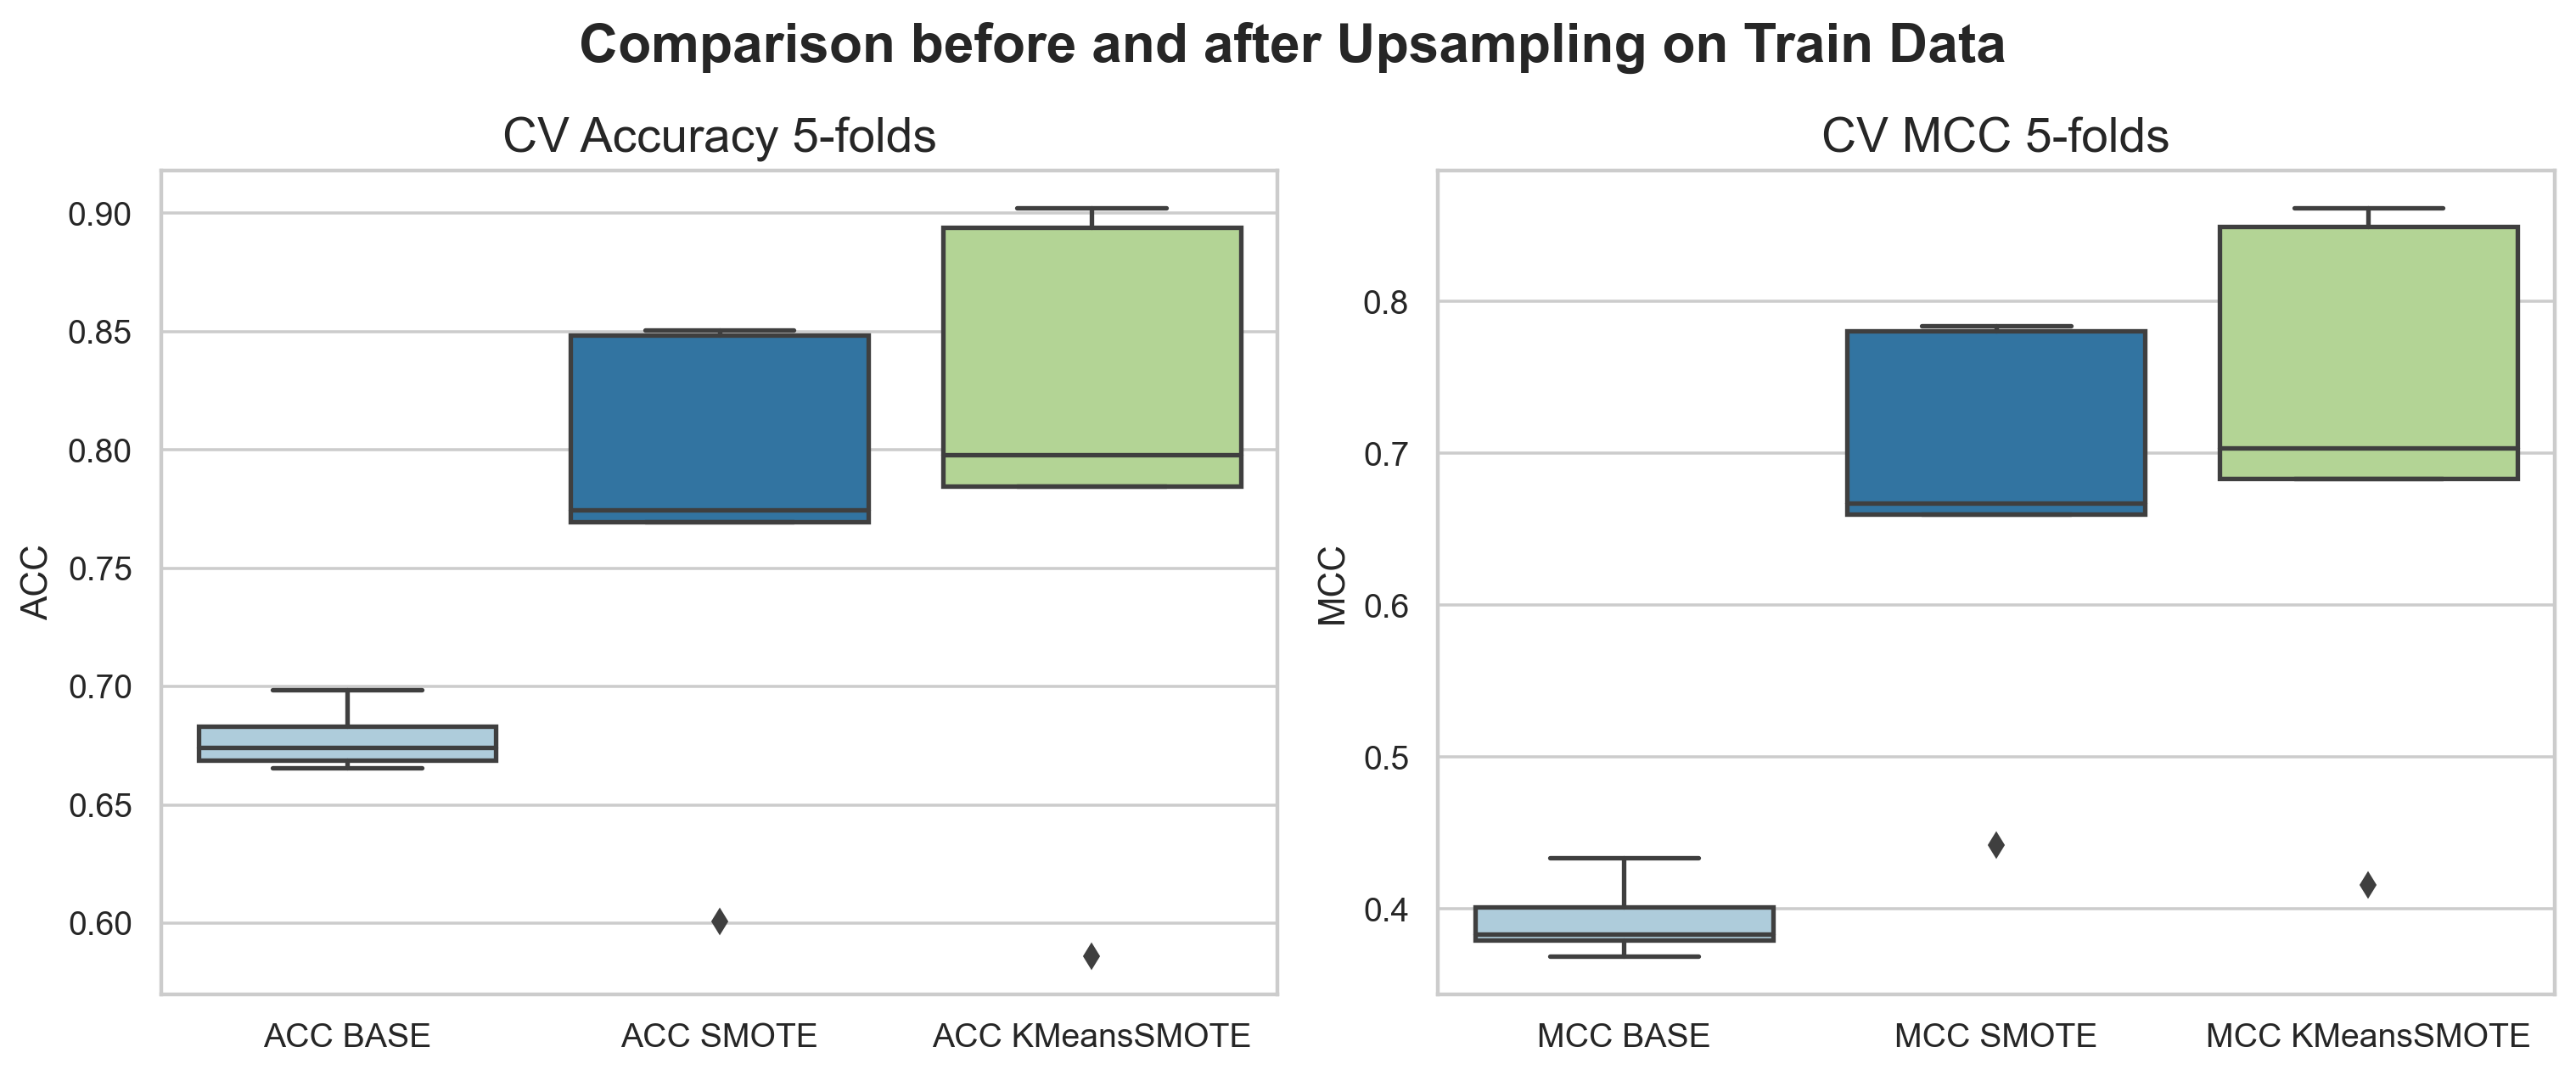

In [75]:
# Costum color for acc and mcc
#custom_colors = ["#a6cee3", "#b2df8a", "#e31a1c"]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5), dpi=256)
fig.suptitle("Comparison before and after Upsampling on Train Data", fontweight="bold", size=18)
sns.boxplot(data=df[[col for col in df.columns if col.startswith("ACC")]], ax=ax[0])#, palette=custom_colors)
ax[0].set_title("CV Accuracy 5-folds", size=16)
ax[0].set_ylabel("ACC")
sns.boxplot(data=df[[col for col in df.columns if col.startswith("MCC")]], ax=ax[1])#, palette=custom_colors)
ax[1].set_title("CV MCC 5-folds", size=16)
ax[1].set_ylabel("MCC")
plt.tight_layout()
plt.show()

In [62]:
def get_comparison_df_hold_out_set(models: list, types: list) -> pd.DataFrame:
    acc_list = []
    mcc_list = []
    for model in models:
        acc, mcc = get_prediction_score(model)
        acc_list.append(acc)
        mcc_list.append(mcc)

    df = pd.DataFrame({
        "ACC": acc_list,
        "MCC": mcc_list,
        "Model": types
    })

    return df


df_val = get_comparison_df_hold_out_set(models=[model, model_post_smote, model_post_kms],
                                        types=["base", "smote", "kmeanssmote"])
df_val

XGBoost model was used. Renaming predictions ...
ACC on validation set: 0.6705
MCC on validation set: 0.3787
XGBoost model was used. Renaming predictions ...
ACC on validation set: 0.6565
MCC on validation set: 0.3624
XGBoost model was used. Renaming predictions ...
ACC on validation set: 0.6670
MCC on validation set: 0.3781


,ACC,MCC,Model
0,0.6705,0.378700,base
1,0.6565,0.362395,smote
2,0.6670,0.378095,kmeanssmote


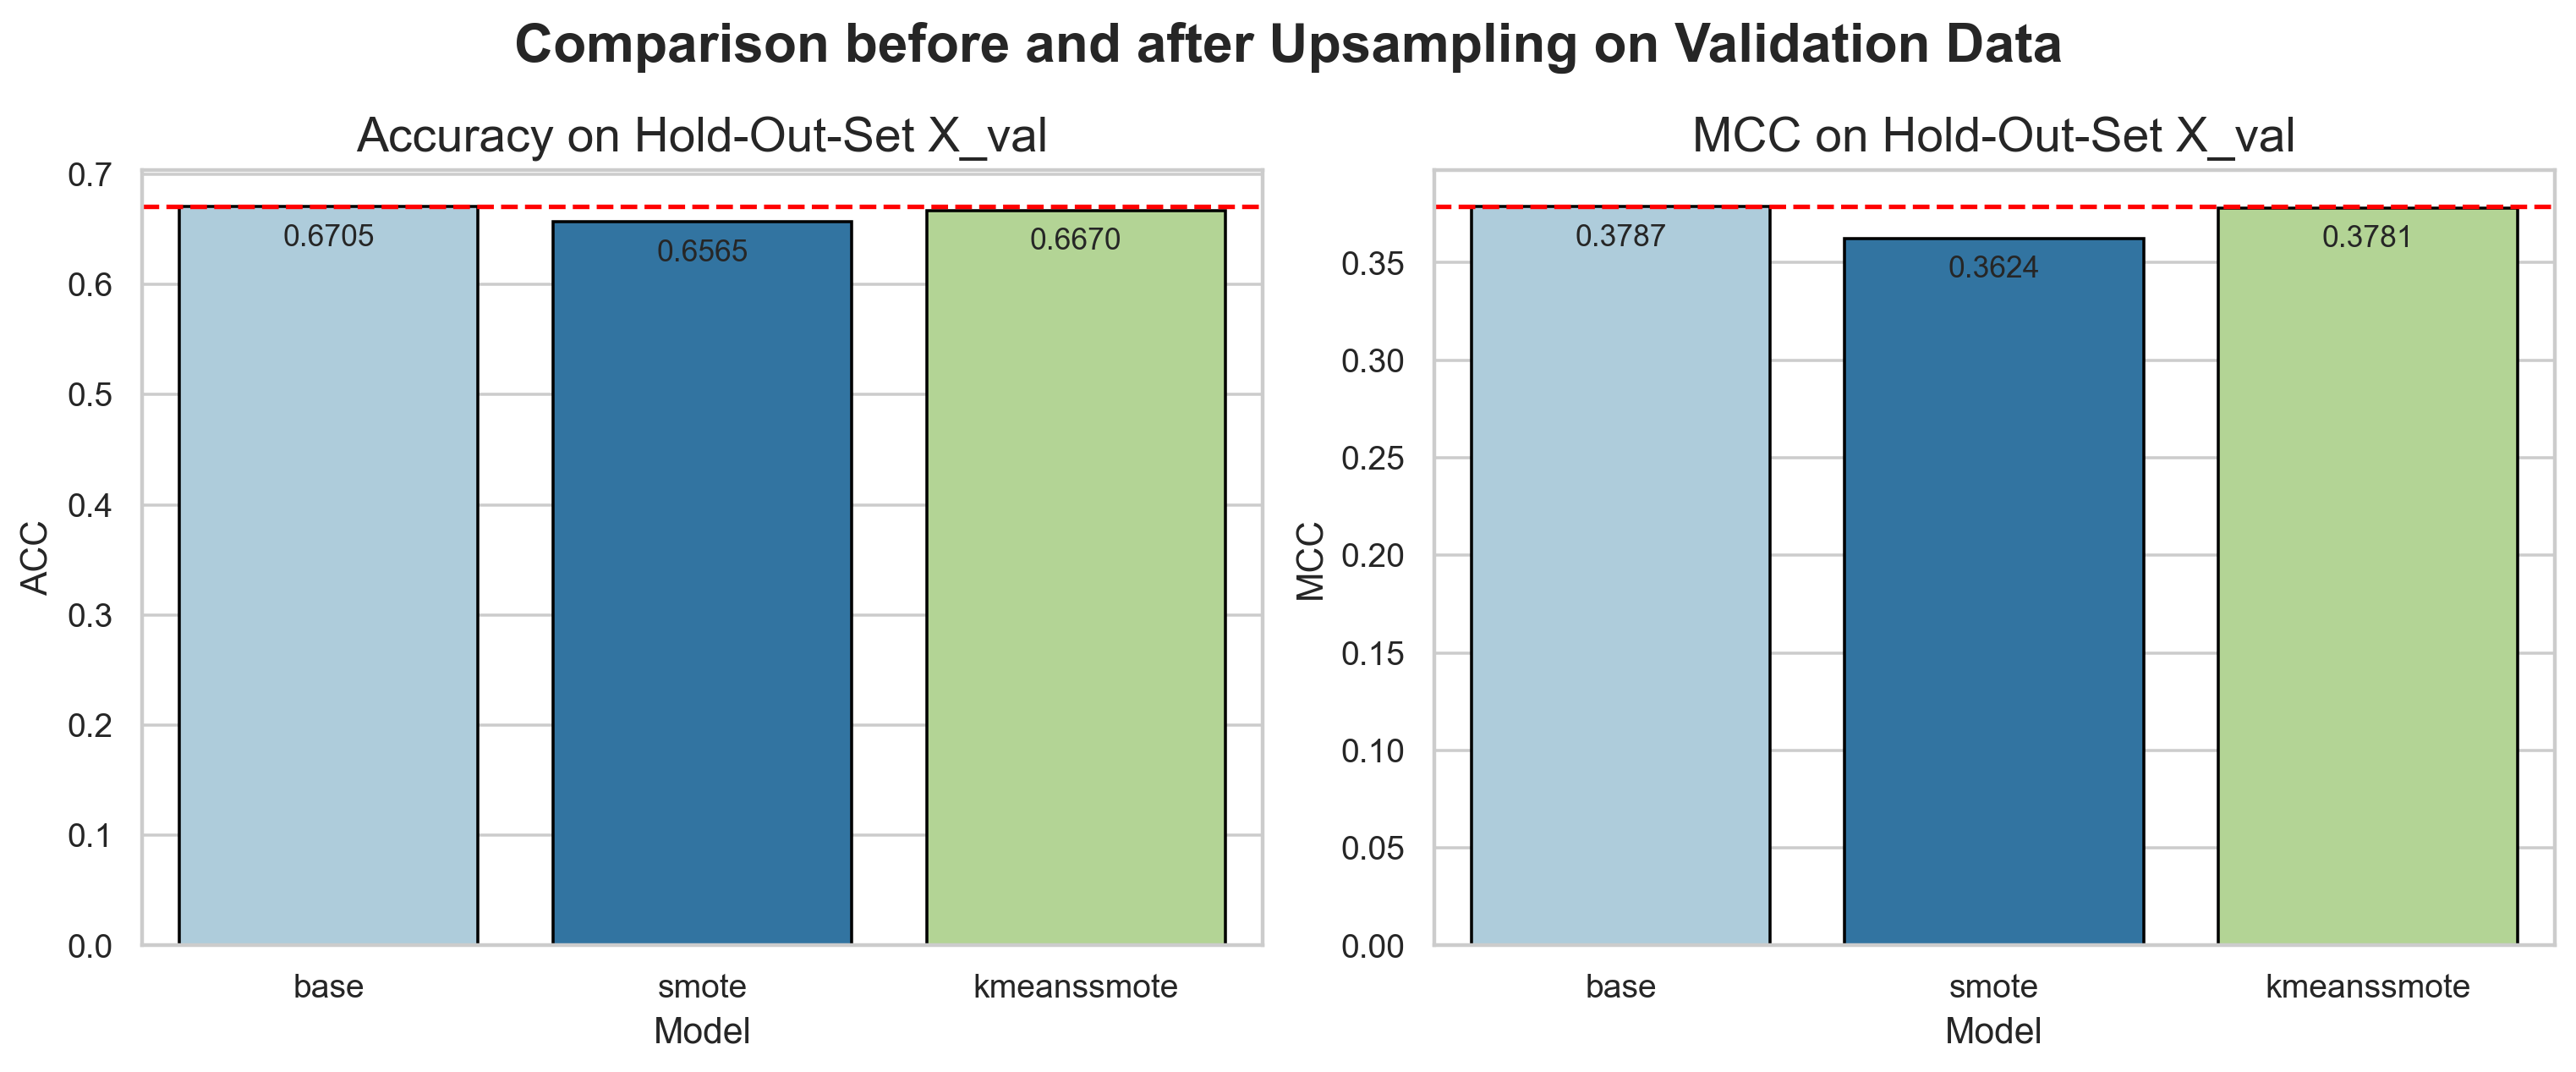

In [81]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5), dpi=256)
fig.suptitle("Comparison before and after Upsampling on Validation Data", fontweight="bold", size=18)
g = sns.barplot(data=df_val, y="ACC", x="Model", ax=ax[0], edgecolor="black")
g.bar_label(g.containers[0], fmt="%.4f", padding=-15)
ax[0].set_title("Accuracy on Hold-Out-Set X_val", size=16)
ax[0].set_ylabel("ACC")
ax[0].axhline(y=df_val.loc[0, "ACC"], color="red", linestyle="--")
h = sns.barplot(data=df_val, y="MCC", x="Model", ax=ax[1], edgecolor="black")
h.bar_label(h.containers[0], fmt="%.4f", padding=-15)
ax[1].set_title("MCC on Hold-Out-Set X_val", size=16)
ax[1].set_ylabel("MCC")
ax[1].axhline(y=df_val.loc[0, "MCC"], color="red", linestyle="--")
plt.tight_layout()
plt.show()